# **Data Analysis**

### This notebook visualizes the different datasets used for Acoustic Anomaly Detection in this project. 

It is structure the following way:
1. Analysis of the Washing Machine dataset
2. Analysis of the Synthetic Anomaly dataset
3. Analysis of the Real Anomaly Dataset

### Imports

In [1]:
# Imports
import os
import librosa
import numpy as np
import soundfile as sf
from scipy.signal import fftconvolve

import matplotlib.pyplot as plt
from matplotlib import ticker

import librosa.display
import numpy as np


### Defining Functions

In [2]:
# Function to generate a normalized Mel-spectrogram
def generate_mel_spectrogram(audio_path):
    audio, sr = librosa.load(audio_path, sr=None)
    stft = librosa.stft(audio, n_fft=1024, hop_length=512)
    mel = librosa.feature.melspectrogram(S=np.abs(stft)**2, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # Normalize to [0, 1]
    mel_db_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())
    return mel_db_norm, sr

In [3]:
# Function to generate overlapping frames from a Mel-spectrogram
def generate_frames(mel_spectrogram, frame_size, hop_size):
    num_frames = (mel_spectrogram.shape[1] - frame_size) // hop_size + 1
    frames = np.zeros((num_frames, mel_spectrogram.shape[0], frame_size))
    for i in range(num_frames):
        start = i * hop_size
        frames[i] = mel_spectrogram[:, start:start + frame_size]
    return frames

In [4]:
# Adjustable parameters
time_per_frame = 0.6  # Duration of one frame in seconds
hop_ratio = 0.2       # Overlap ratio between frames

In [5]:
# Function to visualize a subset of frames for inspection
def plot_frames(frames, num_frames=5, title_prefix="Frame"):
    num_frames = min(num_frames, len(frames))
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    for i in range(num_frames):
        ax = axes[i] if num_frames > 1 else axes
        img = librosa.display.specshow(frames[i], x_axis=None, y_axis="mel", cmap="viridis", ax=ax)
        ax.set_title(f"{title_prefix} {i+1}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# 1. **"12 Washing Machine"**

### Load Dataset

In [46]:
# Paths to audio files
anomalous_audio_path_wm = "../../Data/raw/12_wm/A_12_wm.wav"
anomalous_audio_path_complete_wm = "../../Data/raw/12_wm/A_output_MIC2_2024-11-26_19-12-02_986714.wav"
normal_audio_path_wm = "../../Data/raw/12_wm/N_12_wm.wav"

# Paths for saving frames and datasets
output_anomalous_frames_path = "../../Data/frames/analysis_anomalous_frames_12_washing_machine.npy"
output_normal_frames_path = "../../Data/frames/analysis_normal_frames_12_washing_machine.npy"
output_anomalous_complete_frames_path = "../../Data/frames/analysis_anomalous_complete_frames_12_washing_machine.npy"

# Ensure necessary directories exist
os.makedirs(os.path.dirname(output_anomalous_frames_path), exist_ok=True)

### Generate Mel-Spectrogram

In [47]:
# Generate Mel-spectrograms
mel_anomaly_12_washing_machine, sr_anomaly_12_washing_machine = generate_mel_spectrogram(anomalous_audio_path_wm)
mel_normal_12_washing_machine, sr_normal_12_washing_machine = generate_mel_spectrogram(normal_audio_path_wm)
mel_anomaly_12_complete_washing_machine, sr_anomaly_12_complete_washing_machine = generate_mel_spectrogram(anomalous_audio_path_complete_wm)

In [48]:
# Ensure sampling rates match
assert sr_anomaly_12_washing_machine == sr_normal_12_washing_machine, "Sampling rates do not match!"

### Generate Frames from Mel-Spectrogram

In [49]:
# Calculate frame and hop sizes
hop_length = 512
frame_size = int((time_per_frame * sr_anomaly_12_washing_machine) / hop_length)
hop_size = int(frame_size * hop_ratio)

In [50]:
# Generate frames
frames_anomaly_12_washing_machine = generate_frames(mel_anomaly_12_washing_machine, frame_size, hop_size)
frames_normal_12_washing_machine = generate_frames(mel_normal_12_washing_machine, frame_size, hop_size)
frames_anomaly_12_complete_washing_machine = generate_frames(mel_anomaly_12_complete_washing_machine, frame_size, hop_size)

In [51]:
# Save frames
np.save(output_anomalous_frames_path, frames_anomaly_12_washing_machine)
np.save(output_normal_frames_path, frames_normal_12_washing_machine)
np.save(output_anomalous_complete_frames_path, frames_anomaly_12_complete_washing_machine)

### Plotting

## Normal Washing Machine dataset 

This is a recording of a washing machine in normal operating mode without tumbling shoes.

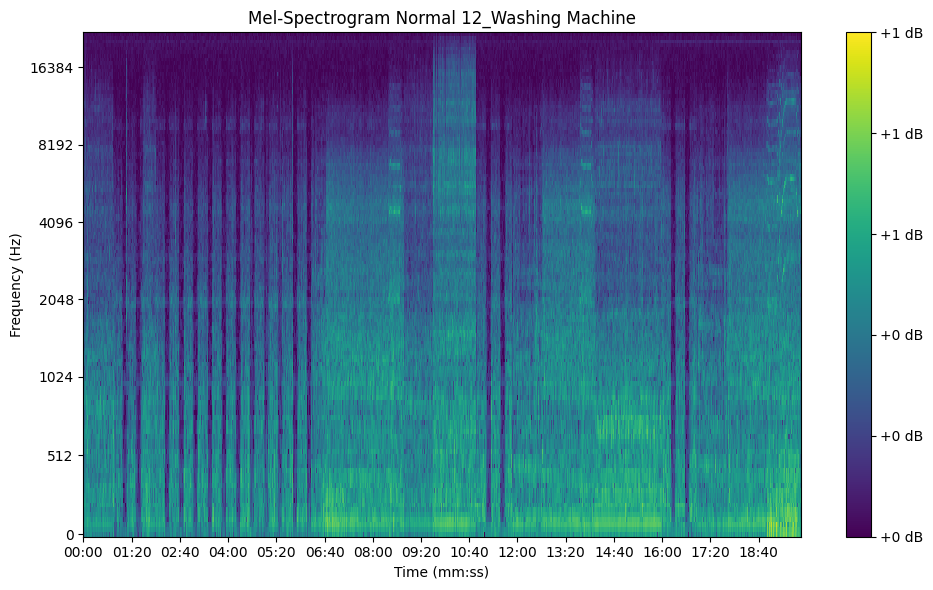

In [56]:
# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Normal Mel-Spectrogram
img1 = librosa.display.specshow(mel_normal_12_washing_machine, sr=sr_normal_12_washing_machine, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
ax.set(title='Mel-Spectrogram Normal 12_Washing Machine', xlabel='Time (mm:ss)', ylabel='Frequency (Hz)')

# Set the x-axis to display only specified part of spectrogram (in seconds)
# ax.set_xlim([14, 28])

# Define a custom function to format the x-axis labels with MM:SS only at the beginning of each minute
def format_time(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    # Show "MM:SS" at the start of each new displayed minute, then only seconds
    if x == ax.get_xlim()[0] or seconds == 0:
        return f"{minutes:02d}:{seconds:02d}"
    else:
        return f"{minutes:02d}:{seconds:02d}"

# Apply the formatter to the x-axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))  # Set 15 ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img1, ax=ax, format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../../Data/mel/mel_spectrogram_12_washing_machine_N.png')
plt.show()

## Complete Anomaly Washing Machine dataset 

This is a recording of a washing machine in normal operating mode with tumbling shoes which should imitate an anomaly.

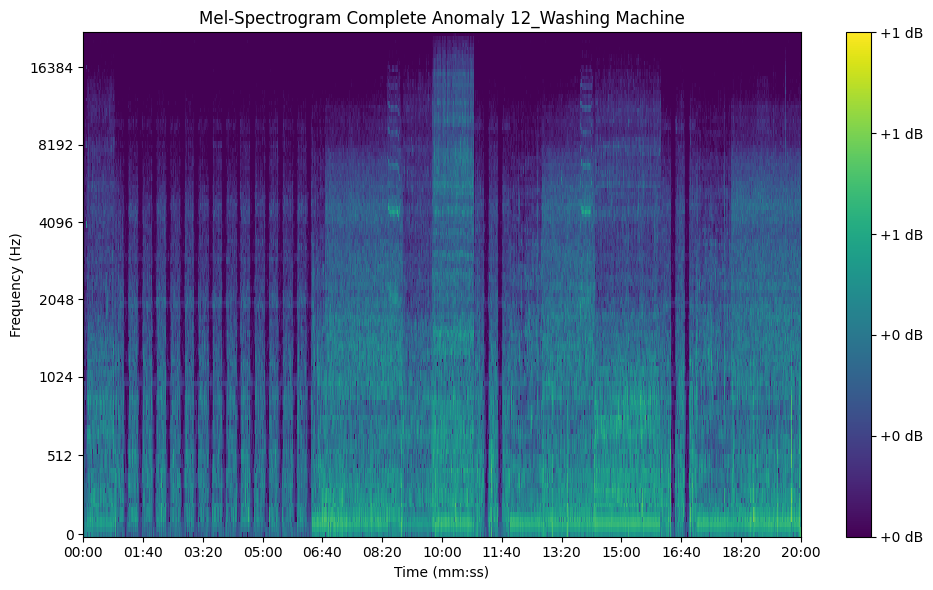

In [58]:
# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Anomaly Mel-Spectrogram
img1 = librosa.display.specshow(mel_anomaly_12_complete_washing_machine, sr=sr_anomaly_12_complete_washing_machine, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
ax.set(title='Mel-Spectrogram Complete Anomaly 12_Washing Machine', xlabel='Time (mm:ss)', ylabel='Frequency (Hz)')

# Set the x-axis to display only specified part of spectrogram (in seconds)
# ax.set_xlim([14, 28])

# Define a custom function to format the x-axis labels with MM:SS only at the beginning of each minute
def format_time(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    # Show "MM:SS" at the start of each new displayed minute, then only seconds
    if x == ax.get_xlim()[0] or seconds == 0:
        return f"{minutes:02d}:{seconds:02d}"
    else:
        return f"{minutes:02d}:{seconds:02d}"

# Apply the formatter to the x-axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))  # Set 15 ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img1, ax=ax, format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../../Data/mel/mel_spectrogram_12_complete_washing_machine_A.png')
plt.show()

## Anomaly Washing Machine dataset 

This is a cut version of the "Complete Anomaly Washing Machine" dataset including only the parts where the tumbling shoes produced a sound.

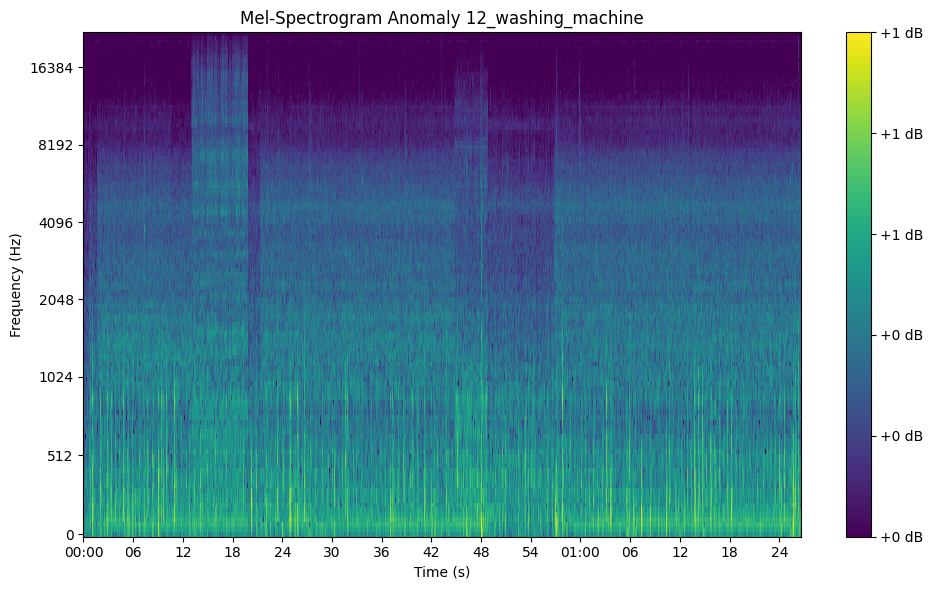

In [13]:
# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Anomaly Mel-Spectrogram
img1 = librosa.display.specshow(mel_anomaly_12_washing_machine, sr=sr_anomaly_12_washing_machine, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
ax.set(title='Mel-Spectrogram Anomaly 12_washing_machine', xlabel='Time (s)', ylabel='Frequency (Hz)')

# Set the x-axis to display only specified part of spectrogram (in seconds)
# ax.set_xlim([14, 28])

# Define a custom function to format the x-axis labels with MM:SS only at the beginning of each minute
def format_time(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    # Show "MM:SS" at the start of each new displayed minute, then only seconds
    if x == ax.get_xlim()[0] or seconds == 0:
        return f"{minutes:02d}:{seconds:02d}"
    else:
        return f"{seconds:02d}"

# Apply the formatter to the x-axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))  # Set 15 ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img1, ax=ax, format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../../Data/mel/mel_spectrogram_12_washing_machine_A.png')
plt.show()

Visualizing frames for anomalous sounds...


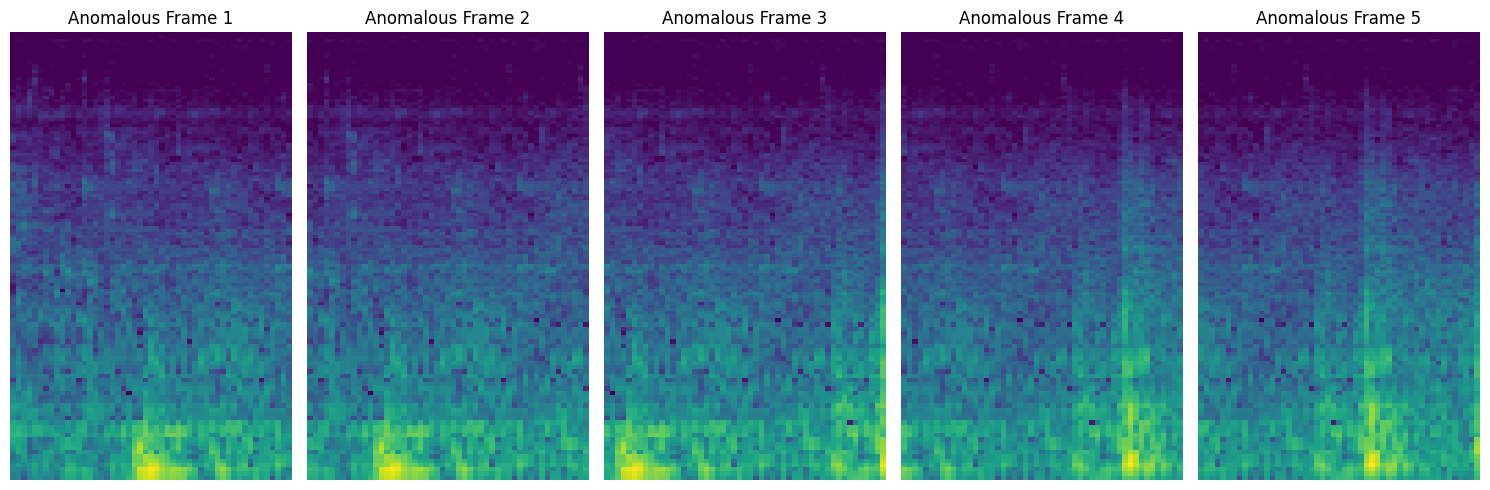

In [14]:
# Visualize anomalous frames
print("Visualizing frames for anomalous sounds...")
plot_frames(frames_anomaly_12_washing_machine, num_frames=5, title_prefix="Anomalous Frame")

Visualizing frames for normal sounds...


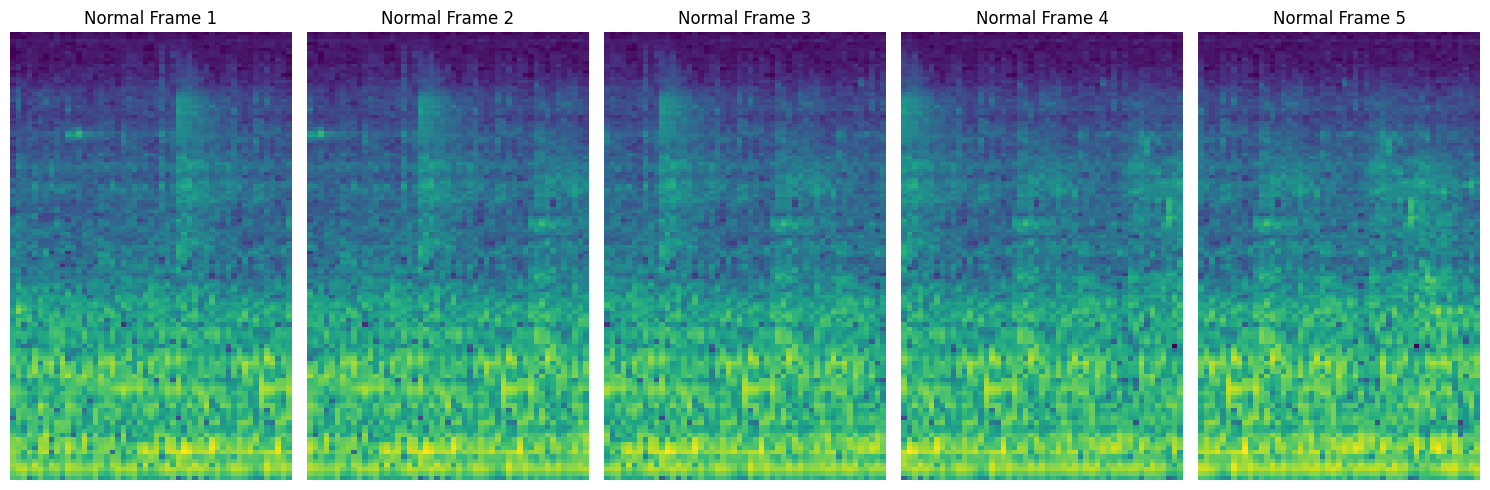

In [15]:
# Visualize normal frames
print("Visualizing frames for normal sounds...")
plot_frames(frames_normal_12_washing_machine, num_frames=5, title_prefix="Normal Frame")

### Observation: 
- Comparing the normal with the complete anomalous (tumbling shoes in empty washing machine) recording we can barely see different patterns. Soley the intensity of the displayed frequencies is slightly stronger in in the normal recording.
- When analyzing the cut anomalies recording, we observe that the noise produced by the shoes tumbling in the machine is clearly visible in the lower frequency area (<500 Hz).
- Overall, it is harder to distinguish between "normal" noise and the sounds generated by the shoes. Therefore, it could be less obvious to distinguish patterns between normal and anomalous sounds.

# 2. **"11 Synthetic Anomalies"**

### Load Dataset

In [16]:
# Paths to audio files
anomalous_audio_path_synthetic = "../../Data/raw/11_synthetic/A_09_10_experiment7_8.wav"
normal_audio_path_synthetic = "../../Data/raw/11_synthetic/N_09_experiment7.wav"
complete_audio_path_synthetic = "../../Data/raw/11_synthetic/A_09_10_experiment7_8.wav"

# Paths for saving frames and datasets
output_anomalous_frames_path = "../../Data/frames/analysis_anomalous_frames_11_synthetic_anomalies.npy"
output_normal_frames_path = "../../Data/frames/analysis_normal_frames_11_synthetic_anomalies.npy"
output_complete_frames_path = "../../Data/frames/analysis_complete_frames_11_synthetic_anomalies.npy"

# Ensure necessary directories exist
os.makedirs(os.path.dirname(output_anomalous_frames_path), exist_ok=True)

### Generate Mel-Spectrogram

In [17]:
# Generate Mel-spectrograms
mel_complete_11_synthetic_anomalies, sr_complete_11_synthetic_anomalies = generate_mel_spectrogram(complete_audio_path_synthetic)
mel_anomaly_11_synthetic_anomalies, sr_anomaly_11_synthetic_anomalies = generate_mel_spectrogram(anomalous_audio_path_synthetic)
mel_normal_11_synthetic_anomalies, sr_normal_11_synthetic_anomalies = generate_mel_spectrogram(normal_audio_path_synthetic)

In [18]:
# Ensure sampling rates match
assert sr_anomaly_11_synthetic_anomalies == sr_normal_11_synthetic_anomalies, "Sampling rates do not match!"

### Generate Frames from Mel-Spectrogram

In [19]:
# Calculate frame and hop sizes
hop_length = 512
frame_size = int((time_per_frame * sr_anomaly_11_synthetic_anomalies) / hop_length)
hop_size = int(frame_size * hop_ratio)

In [20]:
# Generate frames
frames_anomaly_11_synthetic = generate_frames(mel_anomaly_11_synthetic_anomalies, frame_size, hop_size)
frames_normal_11_synthetic = generate_frames(mel_normal_11_synthetic_anomalies, frame_size, hop_size)

In [21]:
# Save frames
np.save(output_anomalous_frames_path, frames_anomaly_11_synthetic)
np.save(output_normal_frames_path, frames_normal_11_synthetic)

## Recording of synthetic anomalies 

This recording was performed by one microphone and occured during one constant operating mode of the powerplant.
- The sythetic anomalies produced by hitting a shovel with a hammer are clearly visible as short high-frequency patterns.

### Plotting

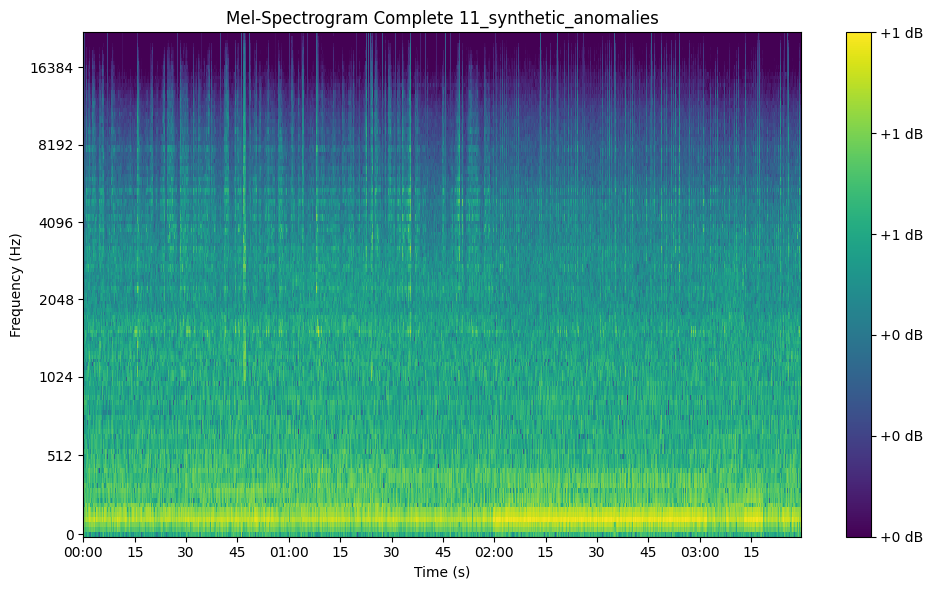

In [22]:
# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Complete Mel-Spectrogram
img1 = librosa.display.specshow(mel_complete_11_synthetic_anomalies, sr=sr_complete_11_synthetic_anomalies, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
ax.set(title='Mel-Spectrogram Complete 11_synthetic_anomalies', xlabel='Time (s)', ylabel='Frequency (Hz)')

# Set the x-axis to display only specified part of spectrogram (in seconds)
# ax.set_xlim([14, 28])

# Define a custom function to format the x-axis labels with MM:SS only at the beginning of each minute
def format_time(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    # Show "MM:SS" at the start of each new displayed minute, then only seconds
    if x == ax.get_xlim()[0] or seconds == 0:
        return f"{minutes:02d}:{seconds:02d}"
    else:
        return f"{seconds:02d}"

# Apply the formatter to the x-axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))  # Set 15 ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img1, ax=ax, format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../../Data/mel/mel_spectrogram_11_synthetic_anomalies_complete.png')
plt.show()

## Normal synthetic dataset 

This dataset was cut from the "Complete Synthetic Anomalies" recording, removing all synthetic anomalies.
- The normal dataset displays a constant image.

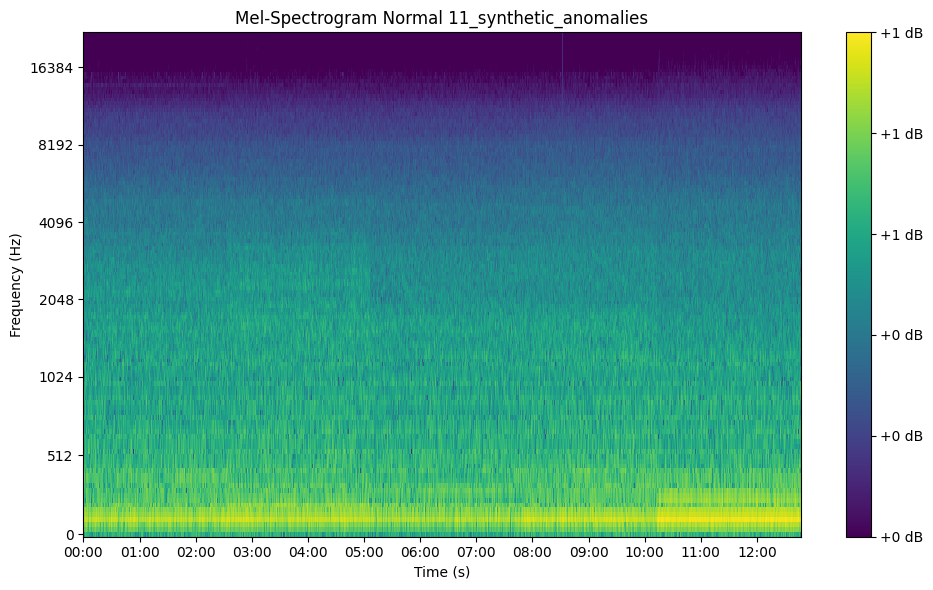

In [23]:
# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Normal Mel-Spectrogram
img1 = librosa.display.specshow(mel_normal_11_synthetic_anomalies, sr=sr_normal_11_synthetic_anomalies, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
ax.set(title='Mel-Spectrogram Normal 11_synthetic_anomalies', xlabel='Time (s)', ylabel='Frequency (Hz)')

# Set the x-axis to display only specified part of spectrogram (in seconds)
# ax.set_xlim([14, 28])

# Define a custom function to format the x-axis labels with MM:SS only at the beginning of each minute
def format_time(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    # Show "MM:SS" at the start of each new displayed minute, then only seconds
    if x == ax.get_xlim()[0] or seconds == 0:
        return f"{minutes:02d}:{seconds:02d}"
    else:
        return f"{seconds:02d}"

# Apply the formatter to the x-axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))  # Set 15 ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img1, ax=ax, format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../../Data/mel/mel_spectrogram_11_synthetic_anomalies_N.png')
plt.show()

## Anomaly synthetic dataset 

This dataset was cut from the "Complete Synthetic Anomalies" recording, keeping all synthetic anomalies.
- The anomaly dataset displays many high-frequency anomalies similar to the "Complete Synthetic Anomalies" dataset, but more thightly compressed.

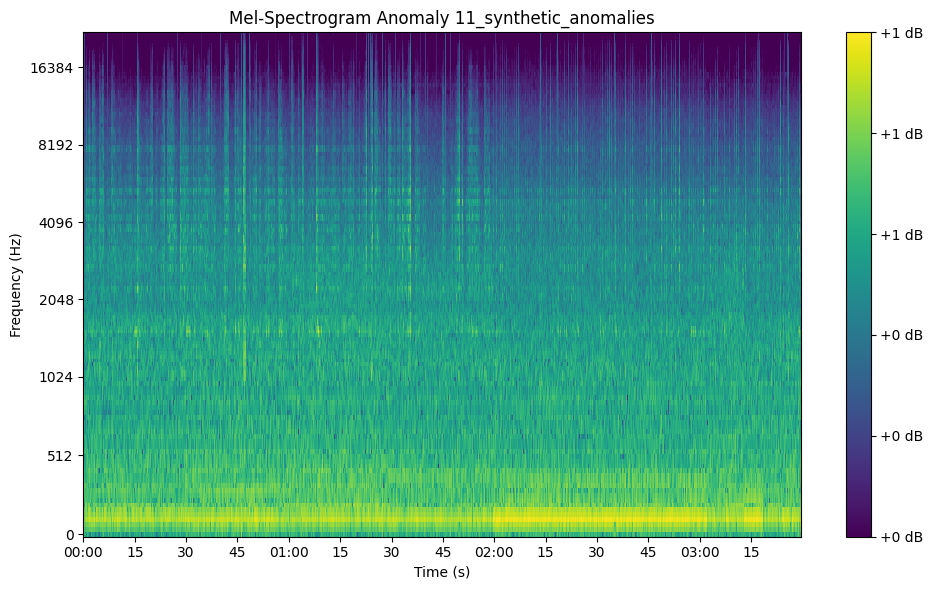

In [24]:
# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Anomaly Mel-Spectrogram
img1 = librosa.display.specshow(mel_anomaly_11_synthetic_anomalies, sr=sr_anomaly_11_synthetic_anomalies, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
ax.set(title='Mel-Spectrogram Anomaly 11_synthetic_anomalies', xlabel='Time (s)', ylabel='Frequency (Hz)')

# Set the x-axis to display only specified part of spectrogram (in seconds)
# ax.set_xlim([14, 28])

# Define a custom function to format the x-axis labels with MM:SS only at the beginning of each minute
def format_time(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    # Show "MM:SS" at the start of each new displayed minute, then only seconds
    if x == ax.get_xlim()[0] or seconds == 0:
        return f"{minutes:02d}:{seconds:02d}"
    else:
        return f"{seconds:02d}"

# Apply the formatter to the x-axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))  # Set 15 ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img1, ax=ax, format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../../Data/mel/mel_spectrogram_11_synthetic_anomalies_A.png')
plt.show()

Visualizing frames for anomalous sounds...


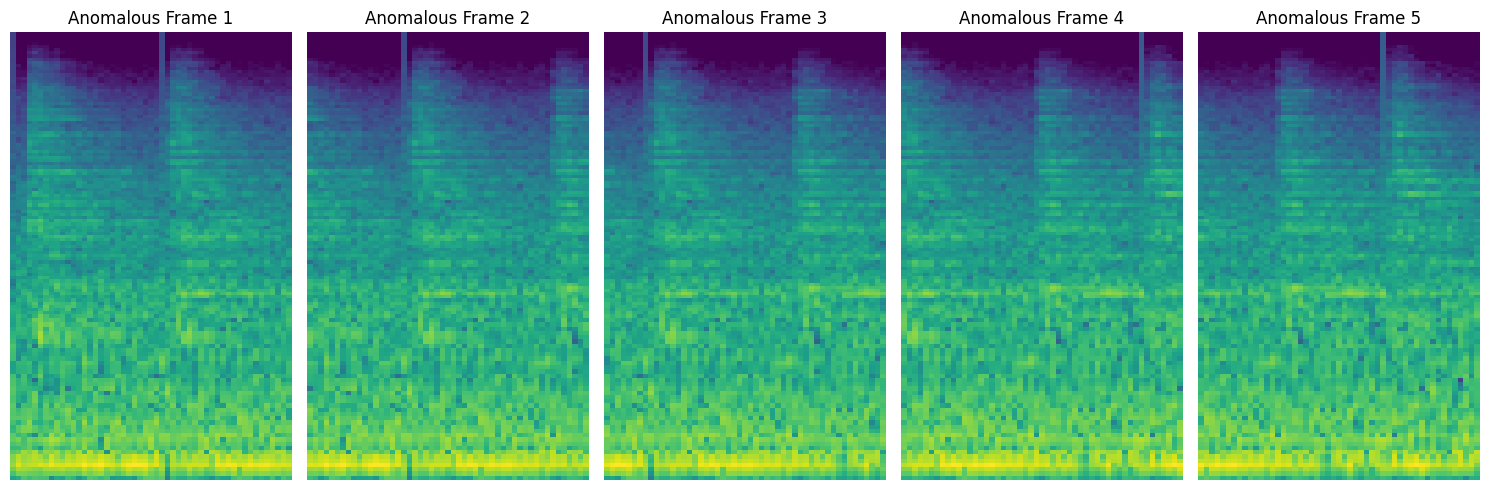

In [25]:
# Visualize anomalous frames
print("Visualizing frames for anomalous sounds...")
plot_frames(frames_anomaly_11_synthetic, num_frames=5, title_prefix="Anomalous Frame")

Visualizing frames for normal sounds...


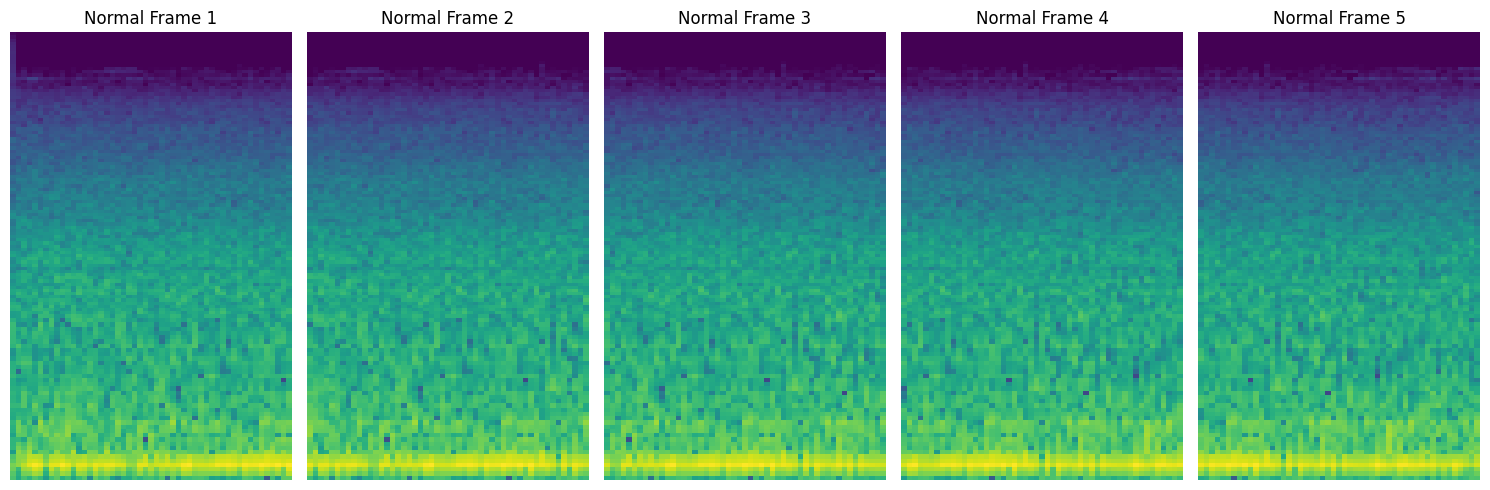

In [26]:
# Visualize normal frames
print("Visualizing frames for normal sounds...")
plot_frames(frames_normal_11_synthetic, num_frames=5, title_prefix="Normal Frame")

### Observation: 
- This dataset was produced by recording normal hydroelectric powerplant machine sounds whilst hitting a shovel with a hammer, simulating short high frequency anomalies.
- We can clearly observe the synthetic anomalies in the higher frequency areas (>1024 HZ).
- In contrast to the washing machine recording, the pattern of the synthetic "normal" vs "anomalous" dataset is clearly distinguishable. THerefore, we assume our models to perform better on this dataset.

# 3. **"13 Real Anomalies"**

### Load Dataset

In [27]:
# Paths to audio files
anomalous_audio_path_real = "../../Data/raw/13_real/Anomaly_knackgeräusche.wav"
normal_audio_path_real = "../../Data/raw/13_real/Normal_knackgeräusche.wav"
complete_audio_path_real = "../../Data/raw/08_livetest_anomalies/output_MIC1_2024-11-07_13-55-00_065414.wav"

# Paths for saving frames and datasets
output_anomalous_frames_path = "../../Data/frames/analysis_anomalous_frames_13_real_anomalies.npy"
output_normal_frames_path = "../../Data/frames/analysis_normal_frames_13_real_anomalies.npy"
output_complete_frames_path = "../../Data/frames/analysis_complete_frames_13_real_anomalies.npy"

# Ensure necessary directories exist
os.makedirs(os.path.dirname(output_anomalous_frames_path), exist_ok=True)

### Generate Mel-Spectrogram

In [30]:
# Generate Mel-spectrograms
mel_complete_13_real_anomalies, sr_complete_13_real_anomalies = generate_mel_spectrogram(complete_audio_path_real)
mel_anomaly_13_real_anomalies, sr_anomaly_13_real_anomalies = generate_mel_spectrogram(anomalous_audio_path_real)
mel_normal_13_real_anomalies, sr_normal_13_real_anomalies = generate_mel_spectrogram(normal_audio_path_real)

In [31]:
# Ensure sampling rates match
assert sr_anomaly_13_real_anomalies == sr_normal_13_real_anomalies, "Sampling rates do not match!"

### Generate Frames from Mel-Spectrogram

In [32]:
# Calculate frame and hop sizes
hop_length = 512
frame_size = int((time_per_frame * sr_anomaly_13_real_anomalies) / hop_length)
hop_size = int(frame_size * hop_ratio)

In [33]:
# Generate frames
frames_anomaly_13_real_anomalies = generate_frames(mel_anomaly_13_real_anomalies, frame_size, hop_size)
frames_normal_13_real_anomalies = generate_frames(mel_normal_13_real_anomalies, frame_size, hop_size)

In [34]:
# Save frames
np.save(output_anomalous_frames_path, frames_anomaly_13_real_anomalies)
np.save(output_normal_frames_path, frames_normal_13_real_anomalies)

### Plotting

## Recording of real anomalies 

This recording was performed by one microphone and includes at least 3 real anomalies which occured during the change of operating modes of the powerplant.
- The operation mode changes are visible through the change in the frequency pattern on the spectrogram.
- The real anomalies are very short, high frequency sounds which are not visible in the complete formate. Therefore, the following spectrograms will show them in a shorter timeframe.

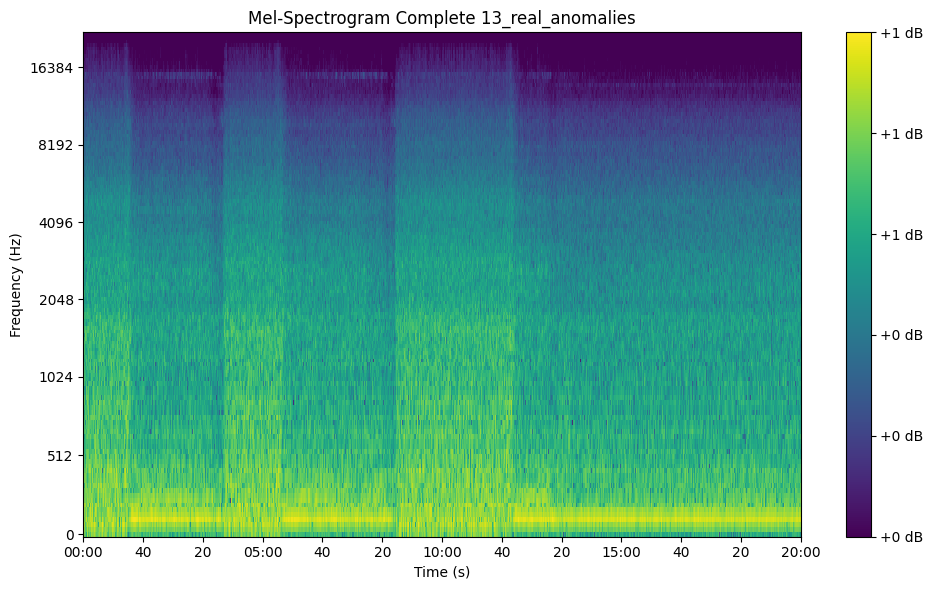

In [35]:
# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Complete Mel-Spectrogram
img1 = librosa.display.specshow(mel_complete_13_real_anomalies, sr=sr_complete_13_real_anomalies, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
ax.set(title='Mel-Spectrogram Complete 13_real_anomalies', xlabel='Time (s)', ylabel='Frequency (Hz)')

# Set the x-axis to display only specified part of spectrogram (in seconds)
# ax.set_xlim([14, 28])

# Define a custom function to format the x-axis labels with MM:SS only at the beginning of each minute
def format_time(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    # Show "MM:SS" at the start of each new displayed minute, then only seconds
    if x == ax.get_xlim()[0] or seconds == 0:
        return f"{minutes:02d}:{seconds:02d}"
    else:
        return f"{seconds:02d}"

# Apply the formatter to the x-axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))  # Set 15 ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img1, ax=ax, format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../../Data/mel/mel_spectrogram_13_real_anomalies_complete.png')
plt.show()

## 1st & 2nd Anomaly

This spectrogram shows the 1st and 2nd clearly visible real anomalies at the 5 minutes 35 and 39 seconds mark.

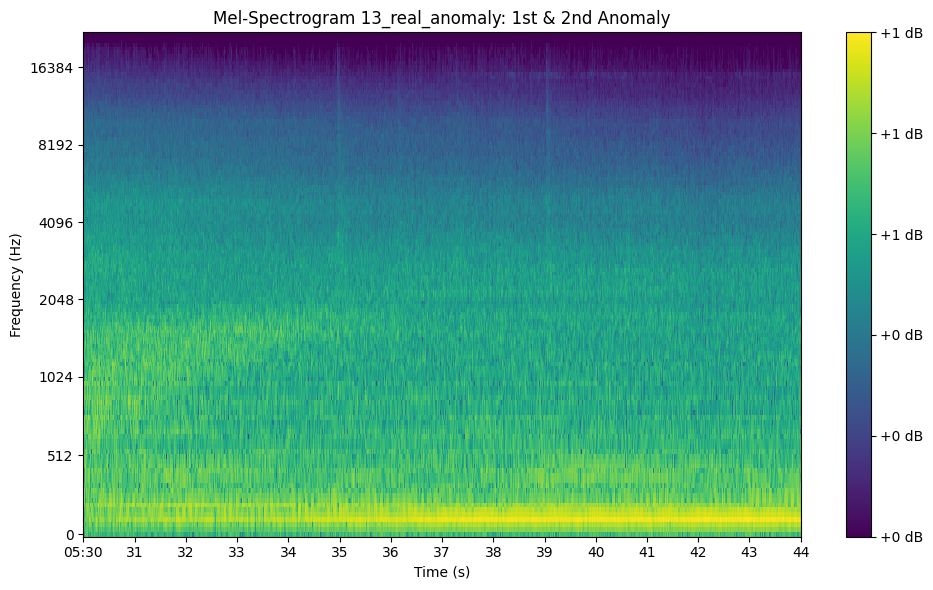

In [36]:
# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Normal Pi1
img1 = librosa.display.specshow(mel_complete_13_real_anomalies, sr=sr_complete_13_real_anomalies, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
ax.set(title='Mel-Spectrogram 13_real_anomaly: 1st & 2nd Anomaly', xlabel='Time (s)', ylabel='Frequency (Hz)')

# Set the x-axis to display only specified part of spectrogram (in seconds)
ax.set_xlim([330, 344])

# Define a custom function to format the x-axis labels with MM:SS only at the beginning of each minute
def format_time(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    # Show "MM:SS" at the start of each new displayed minute, then only seconds
    if x == ax.get_xlim()[0] or seconds == 0:
        return f"{minutes:02d}:{seconds:02d}"
    else:
        return f"{seconds:02d}"

# Apply the formatter to the x-axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Set ticks at every 1 second
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img1, ax=ax, format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.show()

## 3rd Anomaly

This spectrogram shows the 3rd clearly visible real anomaly at the 12 minute 02 seconds mark.

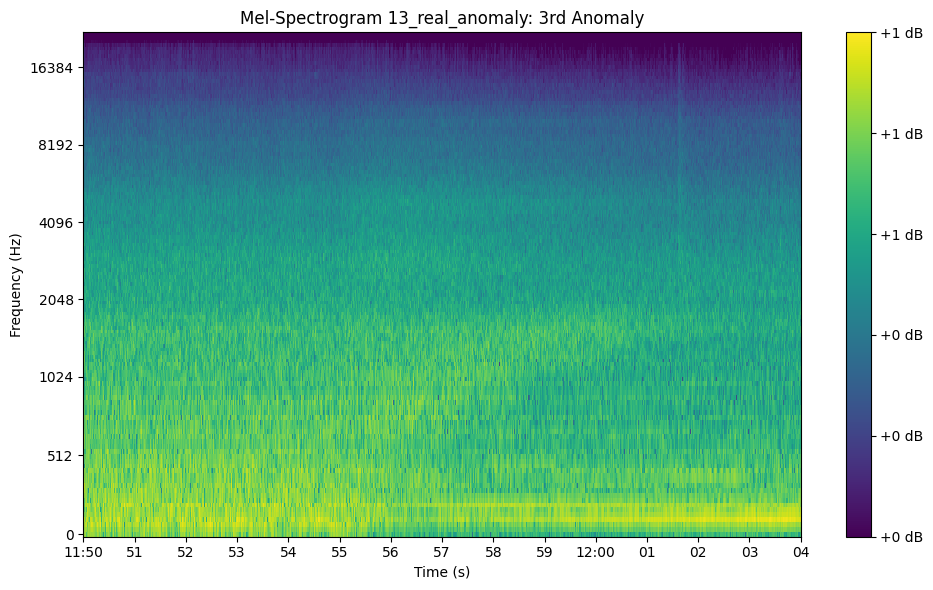

In [37]:
# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Normal Pi1
img1 = librosa.display.specshow(mel_complete_13_real_anomalies, sr=sr_complete_13_real_anomalies, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
ax.set(title='Mel-Spectrogram 13_real_anomaly: 3rd Anomaly', xlabel='Time (s)', ylabel='Frequency (Hz)')

# Set the x-axis to display only specified part of spectrogram (in seconds)
ax.set_xlim([710, 724])

# Define a custom function to format the x-axis labels with MM:SS only at the beginning of each minute
def format_time(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    # Show "MM:SS" at the start of each new displayed minute, then only seconds
    if x == ax.get_xlim()[0] or seconds == 0:
        return f"{minutes:02d}:{seconds:02d}"
    else:
        return f"{seconds:02d}"

# Apply the formatter to the x-axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Set ticks at every 1 second
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img1, ax=ax, format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.show()

## Complete recording with real anomalies

This recording has created from 3 different microphones which recorded simultaneously. Here only the real anomalies were kept. All anomalies from the 3 microphones were concatenated into one dataset.

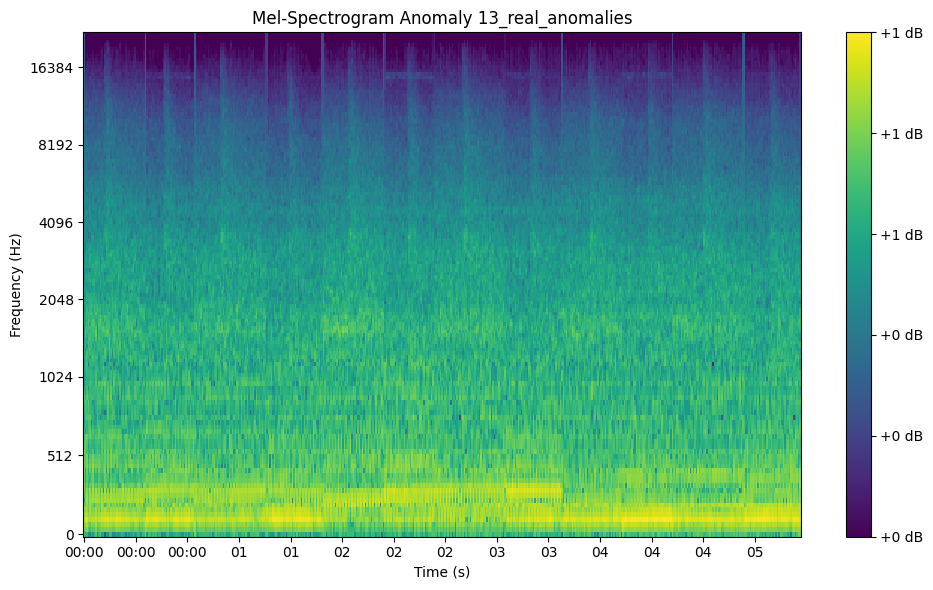

In [55]:
# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Anomaly Mel-Spectrogram
img1 = librosa.display.specshow(mel_anomaly_13_real_anomalies, sr=sr_anomaly_13_real_anomalies, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
ax.set(title='Mel-Spectrogram Anomaly 13_real_anomalies', xlabel='Time (s)', ylabel='Frequency (Hz)')

# Set the x-axis to display only specified part of spectrogram (in seconds)
# ax.set_xlim([14, 28])

# Define a custom function to format the x-axis labels with MM:SS only at the beginning of each minute
def format_time(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    # Show "MM:SS" at the start of each new displayed minute, then only seconds
    if x == ax.get_xlim()[0] or seconds == 0:
        return f"{minutes:02d}:{seconds:02d}"
    else:
        return f"{seconds:02d}"

# Apply the formatter to the x-axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))  # Set 15 ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img1, ax=ax, format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../../Data/mel/mel_spectrogram_13_real_anomalies_A.png')
plt.show()

## Complete recording without anomalies

This recording has created from 3 different microphones which recorded simultaneously. Afterwards the real anomalies were removed and the 3 single recording were concatenated resulting in a "cleaned" dataset used for model training.

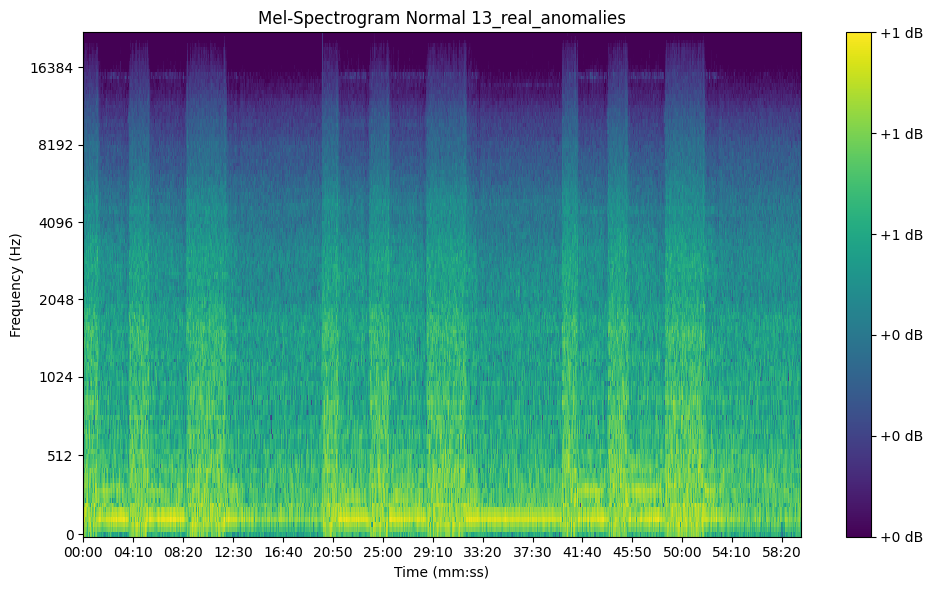

In [ ]:
# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Normal Mel-Spectrogram
img1 = librosa.display.specshow(mel_normal_13_real_anomalies, sr=sr_normal_13_real_anomalies, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
ax.set(title='Mel-Spectrogram Normal 13_real_anomalies', xlabel='Time (mm:ss)', ylabel='Frequency (Hz)')

# Set the x-axis to display only specified part of spectrogram (in seconds)
# ax.set_xlim([14, 28])

# Define a custom function to format the x-axis labels with MM:SS only at the beginning of each minute
def format_time(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    # Show "MM:SS" at the start of each new displayed minute, then only seconds
    if x == ax.get_xlim()[0] or seconds == 0:
        return f"{minutes:02d}:{seconds:02d}"
    else:
        return f"{minutes:02d}:{seconds:02d}"

# Apply the formatter to the x-axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))  # Set 15 ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img1, ax=ax, format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../../Data/mel/mel_spectrogram_13_real_anomalies_N.png')
plt.show()

Visualizing frames for anomalous sounds...


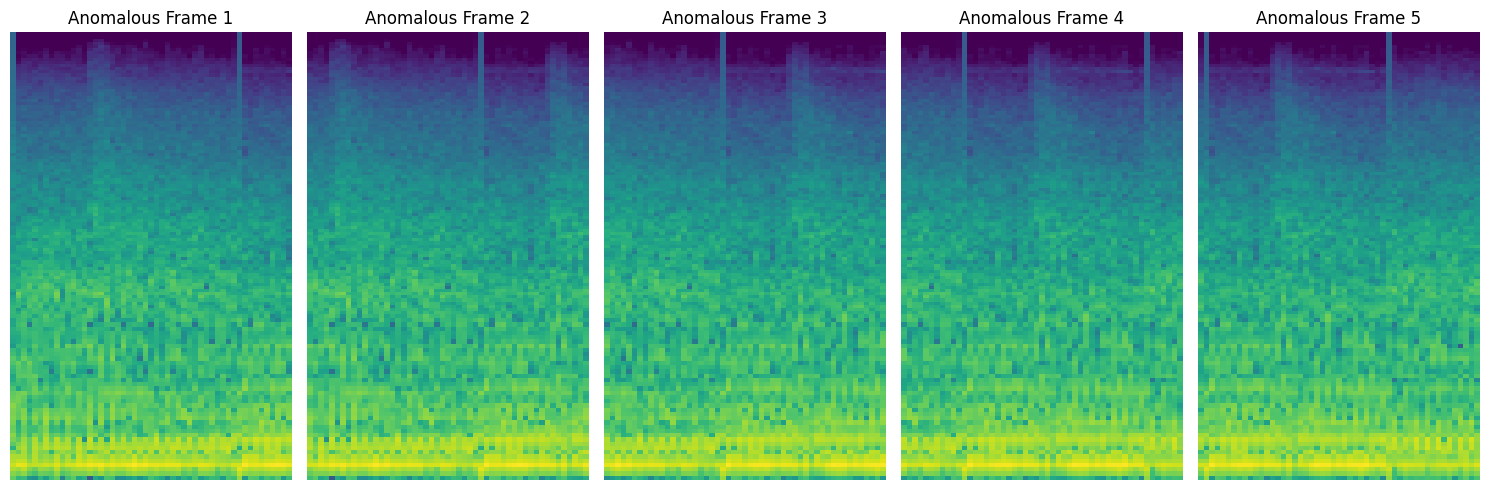

In [40]:
# Visualize anomalous frames
print("Visualizing frames for anomalous sounds...")
plot_frames(frames_anomaly_13_real_anomalies, num_frames=5, title_prefix="Anomalous Frame")

Visualizing frames for normal sounds...


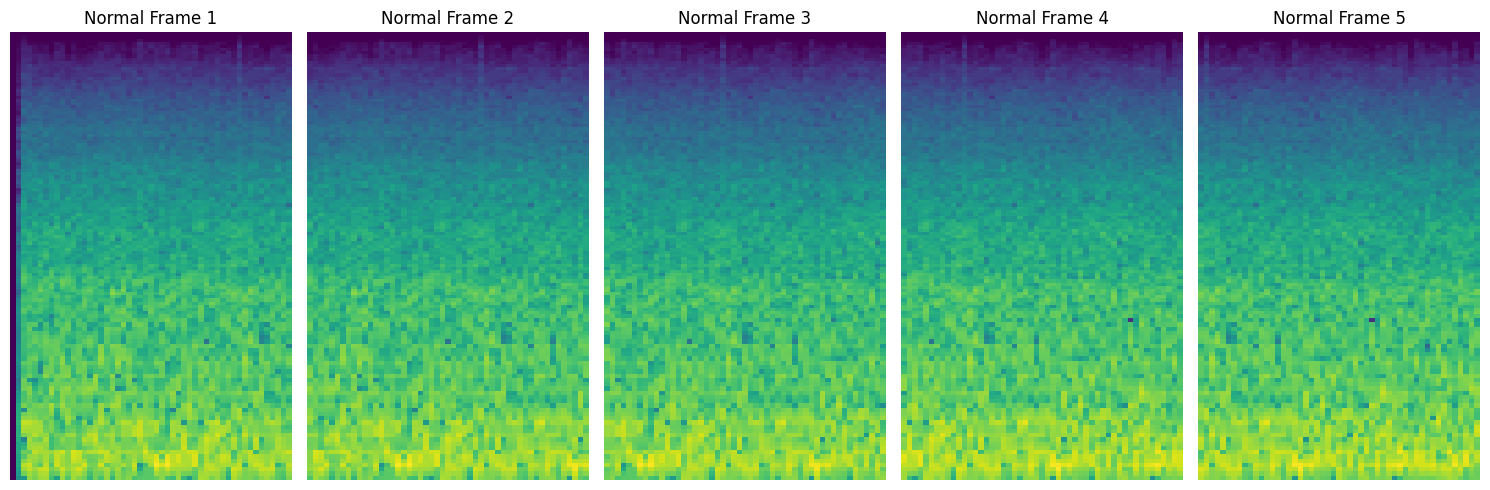

In [41]:
# Visualize normal frames
print("Visualizing frames for normal sounds...")
plot_frames(frames_normal_13_real_anomalies, num_frames=5, title_prefix="Normal Frame")

### Observation: 
- In contrast to the *normal* "synthetic" dataset, the "real" dataset displays different frequencies and was recorded over a longer period of time (approximately 45 minutes longer).
- In contrast to the *anomalous* "synthetic" dataset, the "real" dataset contains far fewer anomalies. Nevertheless, the pattern and frequency of the real anomalies is similar to the synthetic anomalies but with less intensity.